# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Cлучайный лес. Бустинг. Регуляризация логистической регрессии. <br>
## Вариант 28<br>
## ПМИ3-1, Чижевский И.М.

## Список столбцов файла `default_of_credit_card_clients.csv` (исходные данные):

---
- LIMIT_BAL – размер выданного кредита (новых тайваньских долларов);
- SEX – пол: 1 = мужской, 2 = женский;
- EDUCATION – образование: 1 = аспирантура, 2 = университет, 3 = старшая школа, 4 = другое;
- MARRIAGE – семейное положение: 1 = женат/замужем, 2 = одинок, 3 = другое;
- AGE – возраст, лет;
- PAY_0, PAY_2, ..., PAY_6 – статус последних ежемесячных платежей, с сентября (PAY_0) по апрель (PAY_6) 2005 года: -1 = платёж внесён вовремя, 1 = платёж внесён с опозданием на 1 месяц; 2 = с опозданием на 2 месяца, и т.д., 9 = с опозданием на 9 месяцев и более;
- BILL_AMT1, ..., BILL_AMT6 – размер последних ежемесячных платежей (новых тайваньских долларов), с сентября (BILL_AMT1) по апрель (BILL_AMT6) 2005 года;
- PAY_AMT1, ..., PAY_AMT6 – размер ежемесячных платежей в предыдущем месяце (новых тайваньских долларов), с сентября (PAY_AMT1 за август) по апрель (PAY_AMT6 за март) 2005 года;
- Y – целевая переменная: дефолт в следующем месяце (1 – да, 0 – нет).
---

Метод построения модели: **Случайный лес**

In [28]:
# настройка ширины страницы блокнота
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# загрузка пакетов
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
from pathlib import Path
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from scipy.stats import chi2_contingency
import time

# модели и метрики
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

# константы
my_seed = 28  # номер варианта как seed

In [29]:
url = "https://raw.githubusercontent.com/aksyuk/MTML/refs/heads/main/Labs/data/default_of_credit_card_clients.csv"

if not Path(url).exists():
    urllib.request.urlretrieve(url)
    print(f"Файл загружен: {url}")
else:
    print(f"Файл уже существует: {url}")

# чтение данных
data = pd.read_csv(url)

# Проверка первых строк и структуры
print(data.shape)
print(data.head())

Файл загружен: https://raw.githubusercontent.com/aksyuk/MTML/refs/heads/main/Labs/data/default_of_credit_card_clients.csv
(30000, 24)
   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       3261         0      1000      1000   
2      0  ...      14331      14948      15549      1518      1500      1000   
3      0  ...      28314      28959      29547      2000      2019      1200   
4      0  ...  

In [30]:
print(data.columns)

# Проверка типов данных
print(data.dtypes)

# Проверка пропусков
print(data.isnull().sum())


Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y'],
      dtype='object')
LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
Y            int64
dtype: object
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT

In [31]:
# Разделение данных
train_data, test_data = train_test_split(data, test_size=0.15, random_state=my_seed)
print(f"Обучающая выборка: {train_data.shape}")
print(f"Отложенная выборка: {test_data.shape}")

# Отделяем целевую переменную Y
X_train = train_data.drop('Y', axis=1)
y_train = train_data['Y']
X_test = test_data.drop('Y', axis=1)
y_test = test_data['Y']

Обучающая выборка: (25500, 24)
Отложенная выборка: (4500, 24)


##Построение модели дерева с обрезкой ветвей


Accuracy дерева без обрезки (CV): 0.780


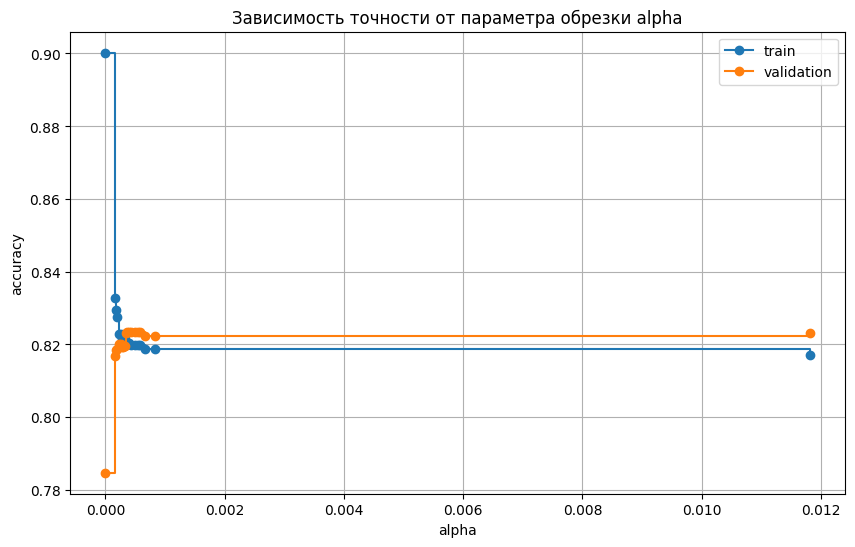

Оптимальное значение alpha: 0.00036601307189542494
Accuracy обрезанного дерева (CV): 0.819


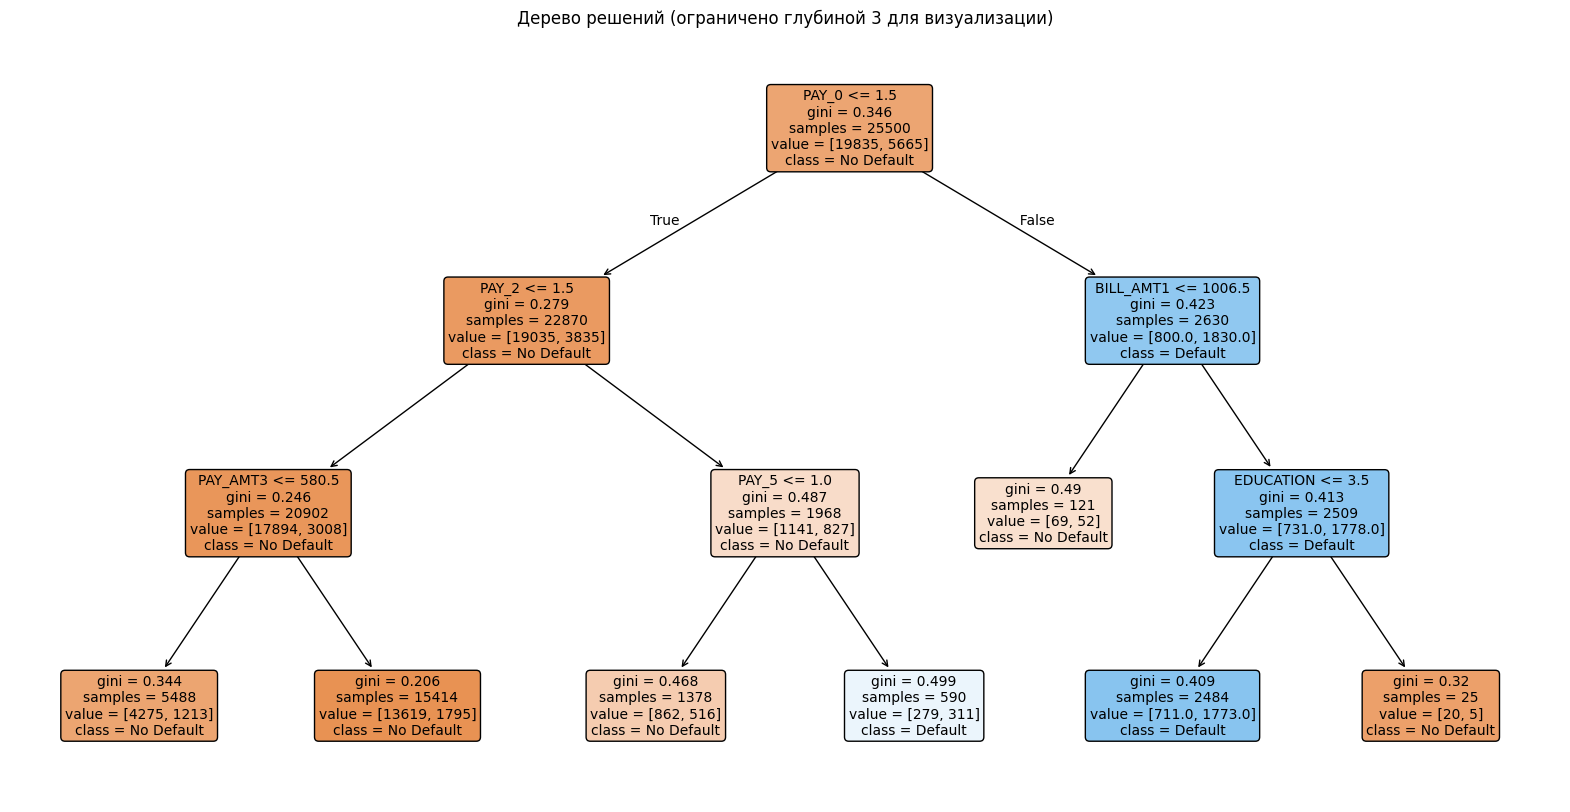

In [32]:
#Дерево классификации без обрезки (ограничим глубину для ускорения)
tree_full = DecisionTreeClassifier(random_state=my_seed, max_depth=15)
tree_full.fit(X_train, y_train)

# Оценка точности с перекрёстной проверкой (уменьшим cv для скорости)
cv_scores_tree_full = cross_val_score(tree_full, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
print(f"Accuracy дерева без обрезки (CV): {np.mean(cv_scores_tree_full):.3f}")

#Обрезка дерева (используем подвыборку данных для ускорения)
# Будем использовать подвыборку (20%) для вычисления пути обрезки
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train,
                                                         train_size=0.2,
                                                         random_state=my_seed)

path = tree_full.cost_complexity_pruning_path(X_train_sample, y_train_sample)
ccp_alphas = path.ccp_alphas
# Убираем последнее тривиальное значение
if len(ccp_alphas) > 0:
    ccp_alphas = ccp_alphas[:-1]

# Ограничим количество проверяемых alpha для скорости
if len(ccp_alphas) > 50:
    # Берем равномерно распределенные alpha
    indices = np.linspace(0, len(ccp_alphas)-1, 20, dtype=int)
    ccp_alphas = ccp_alphas[indices]

# Создаем отдельную валидационную выборку для оценки
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train,
                                                          test_size=0.2,
                                                          random_state=my_seed)

train_scores = []
val_scores = []
trees = []

for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=my_seed, max_depth=15, ccp_alpha=alpha)
    tree.fit(X_train_sub, y_train_sub)
    trees.append(tree)
    train_scores.append(tree.score(X_train_sub, y_train_sub))
    val_scores.append(tree.score(X_val, y_val))

# График зависимости точности от alpha
plt.figure(figsize=(10,6))
plt.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
plt.plot(ccp_alphas, val_scores, marker='o', label='validation', drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Зависимость точности от параметра обрезки alpha")
plt.legend()
plt.grid(True)
plt.show()

# Оптимальное alpha по максимальной точности на валидации
if len(val_scores) > 0:
    idx_optimal = np.argmax(val_scores)
    optimal_alpha = ccp_alphas[idx_optimal]
    print(f"Оптимальное значение alpha: {optimal_alpha}")

    # Дерево с оптимальной обрезкой
    tree_pruned = DecisionTreeClassifier(random_state=my_seed, max_depth=15, ccp_alpha=optimal_alpha)
    tree_pruned.fit(X_train, y_train)

    # Оценка точности обрезанного дерева
    cv_scores_pruned = cross_val_score(tree_pruned, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    print(f"Accuracy обрезанного дерева (CV): {np.mean(cv_scores_pruned):.3f}")

    # Попробуем визуализировать дерево с ограничением глубины
    tree_viz = DecisionTreeClassifier(random_state=my_seed, max_depth=3, ccp_alpha=optimal_alpha)
    tree_viz.fit(X_train, y_train)

    plt.figure(figsize=(20,10))
    plot_tree(tree_viz, feature_names=X_train.columns, class_names=['No Default', 'Default'],
              filled=True, rounded=True, fontsize=10)
    plt.title("Дерево решений (ограничено глубиной 3 для визуализации)")
    plt.show()
else:
    print("Не удалось найти оптимальное alpha")

##Построение модели случайного леса с оптимизацией параметров

In [33]:
##сеточный поиск
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10, 50],
    'min_samples_leaf': [1, 5, 10]
}

sample_size = min(5000, len(X_train))
X_train_sample = X_train.sample(n=sample_size, random_state=my_seed)
y_train_sample = y_train.loc[X_train_sample.index]

rf = RandomForestClassifier(random_state=my_seed, n_jobs=-1)
kfold = KFold(n_splits=3, shuffle=True, random_state=my_seed)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Начинаем сеточный поиск...")
start_time = time.time()
grid_search.fit(X_train_sample, y_train_sample)
end_time = time.time()

print(f"Время выполнения сеточного поиска: {end_time - start_time:.2f} сек")
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность (CV): {grid_search.best_score_:.3f}")

#Обучим финальную модель на всех данных с лучшими параметрами
best_rf = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=my_seed,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

# Оценка точности с кросс-валидацией
cv_scores_rf = cross_val_score(best_rf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
print(f"Accuracy случайного леса на полных данных (CV): {np.mean(cv_scores_rf):.3f}")

Начинаем сеточный поиск...
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Время выполнения сеточного поиска: 414.49 сек
Лучшие параметры: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimators': 100}
Лучшая точность (CV): 0.821
Accuracy случайного леса на полных данных (CV): 0.819


##Выбор наиболее точной модели

In [34]:
# Сравнение accuracy на кросс-валидации
if 'cv_scores_pruned' in locals() and 'cv_scores_rf' in locals():
    acc_tree_pruned = np.mean(cv_scores_pruned)
    acc_rf = np.mean(cv_scores_rf)

    print(f"Accuracy обрезанного дерева: {acc_tree_pruned:.3f}")
    print(f"Accuracy случайного леса: {acc_rf:.3f}")

    if acc_rf > acc_tree_pruned:
        best_model = best_rf
        best_model_name = "Случайный лес"
        print("Наиболее точная модель: Случайный лес")
    else:
        best_model = tree_pruned
        best_model_name = "Обрезанное дерево"
        print("Наиболее точная модель: Обрезанное дерево")
else:
    print("Не удалось оценить все модели. Проверьте выполнение предыдущих шагов.")

Accuracy обрезанного дерева: 0.819
Accuracy случайного леса: 0.819
Наиболее точная модель: Случайный лес


##Прогноз на отложенных наблюдениях



In [35]:
# Прогноз и оценка точности на тестовой выборке
if 'best_model' in locals():
    y_pred = best_model.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_pred)

    print(f"\nОценка точности на отложенных наблюдениях для модели '{best_model_name}':")
    print(f"Accuracy: {accuracy_test:.3f}")
    print("\nОтчёт по классификации:")
    print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))
else:
    print("Лучшая модель не определена.")


Оценка точности на отложенных наблюдениях для модели 'Случайный лес':
Accuracy: 0.826

Отчёт по классификации:
              precision    recall  f1-score   support

  No Default       0.85      0.95      0.90      3529
     Default       0.67      0.39      0.49       971

    accuracy                           0.83      4500
   macro avg       0.76      0.67      0.69      4500
weighted avg       0.81      0.83      0.81      4500

